In [4]:
%matplotlib widget
from dorna_vision import util, draw
import matplotlib.pyplot as plt
from camera import Camera
from dorna2 import Dorna, Kinematic
import cv2
import numpy as np
import itertools
from scipy.optimize import minimize
from IPython.display import display, clear_output

In [5]:
"""
System parameters
"""
# robot
robot_ip = "192.168.254.30"# robot ip address 
robot_model = "dorna_ta"

# aruco
aruco_id = 17
aruco_length=24 # mm
aruco_dic="DICT_4X4_100"
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False
aruco_coordinate="CCW"

# search area
joint_deviation = np.array(list(itertools.product([-5, 0, 5], [-5, 0, 5], [-5, 0, 5], [-5, 0, 5], [-5, 0, 5],[0])))

# collected data
collected_data = []

In [6]:
"""
helper functions
"""
# euler to transformation matrix
def Euler_matrix(abg,xyz):
    cv0 = np.cos(abg[0])
    sv0 = np.sin(abg[0])
    cv1 = np.cos(abg[1])
    sv1 = np.sin(abg[1])
    cv2 = np.cos(abg[2])
    sv2 = np.sin(abg[2])
    return np.matrix([
        [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyz[0]  ],
        [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyz[1]  ],
        [-sv1       , sv2*cv1               , cv2*cv1               , xyz[2]  ],
        [0,0,0,1]])


def likelihood(p, kinematic, data, use_aruco, use_ground_truth):
    # init error
    total_error = 0
    
    T_cam_2_j4 = Euler_matrix([p[3],p[4],p[5]],[p[0],p[1],p[2]])
    num_data = 0

    for point_set in data:
        v =[]
        for idx in range(len(point_set)):
            gt = []
            if use_aruco:
                gt = point_set[idx]["aruco_t_target_2_cam"]
            else:
                gt = point_set[idx]["t_target_2_cam"]

            g = np.matmul(np.matmul(kinematic.Ti_r_world(i=5, joint=point_set[idx]["joint"]), np.matrix(T_cam_2_j4)), 
                np.vstack((np.reshape(gt, (3,1) ), np.array([[1]]))))
            v.append([g[0,0],g[1,0],g[2,0]])
            num_data = num_data + 1
        
        # centroid
        centroid = None
        if len(point_set[0]["t_target_2_base"])==0:
            centroid = np.mean(v, axis=0)
        else:
            if(use_ground_truth):
                centroid =  point_set[0]["t_target_2_base"]
            else:
                centroid = np.mean(v, axis=0)

        # error vector     
        a = np.array([np.linalg.norm(np.array(g) - np.array(centroid)) for g in v])
        total_error = total_error + sum(a)

    print("Error in mm: : ", total_error/num_data)

    return total_error

def minimizer(data, kinematic, use_ground_truth=True, use_aruco=False):
    # minimize
    f = minimize(likelihood, x0=[0,0,0,0,0,0], args = (kinematic, data,use_aruco, use_ground_truth))

    # result
    T_cam_2_j4 = Euler_matrix([f.x[3],f.x[4],f.x[5]],[f.x[0],f.x[1],f.x[2]])

    return T_cam_2_j4


def dorna_ta_eye_in_hand_camera_kit(robot, kinematic, camera, joint_deviation, aruco_id, aruco_length, aruco_dic, aruco_refine, aruco_subpix, aruco_coordinate):
    # init
    retval = []
    
    # record t_target_2_base
    touching = input("The robot is touching the aruco marker (Y or N):")
    touching = touching.lower()

    # init centroid
    xyz_target_2_base = []
    if touching == "y":
        xyz_target_2_base = robot.get_all_pose()[0:3]
        
        #go up
        robot.set_motor(1)
        robot.sleep(1)
        robot.lmove(rel=1, z=120, vel=100, accel=1000, jerk=2000)
        robot.lmove(rel=1, x=-40, y=30, vel=100, accel=1000, jerk=2000)
        robot.sleep(1)
    
    # initial joint
    initial_joint = np.array(robot.get_all_joint()[0:6])
    target_joint_list = [(initial_joint +  joint).tolist() for joint in joint_deviation]
    
    # Generate all possible lists of size 5    
    for joint in target_joint_list:
        for i in range(1):
            robot.jmove(rel=0, vel=50, accel=800, jerk=1000, j0=joint[0], j1=joint[1], j2=joint[2], j3=joint[3], j4=joint[4], j5=joint[5])
            robot.sleep(1)
    
            # capture image
            depth_frame, _, _, _, _, color_img, depth_int, _, _= camera.get_all()
    
            # joint
            joint = robot.get_all_joint()[0:6]
            
            # search_id pose: [[id, corner, rvec, tvec] for id, corner, rvec, tvec in zip(aruco_id, aruco_corner, rvecs, tvecs)]
            aruco_data = util.find_aruco(color_img, camera.camera_matrix(depth_int), camera.dist_coeffs(depth_int), dictionary=aruco_dic, marker_length=aruco_length, refine=aruco_refine, subpix=aruco_subpix, coordinate=aruco_coordinate)
            
            # find aruco_id
            pxl_target_2_cam = []
            for val in aruco_data:
                if val[0] == aruco_id: # find center pixel
                    corner = val[1]
                    pxl_x = (corner[0][0][0] + corner[0][1][0] + corner[0][2][0] + corner[0][3][0]) / 4
                    pxl_y = (corner[0][0][1] + corner[0][1][1] + corner[0][2][1] + corner[0][3][1]) / 4
                    pxl_target_2_cam = [pxl_x, pxl_y]
                    break
            
            # aruco not found
            if pxl_target_2_cam == []:
                break

            # target to camera
            xyz_target_2_cam, _ = camera.xyz(pxl_target_2_cam, depth_frame, depth_int)

            # append collect data
            retval.append({"joint": joint, "t_target_2_cam": xyz_target_2_cam.tolist(), "t_target_2_base": xyz_target_2_base, "aruco_t_target_2_cam": val[3].tolist()[0], "aruco_r_target_2_cam": cv2.Rodrigues(val[2])[0].tolist()})

            # draw aruco
            draw.draw_aruco(color_img, aruco_data, camera.camera_matrix(depth_int), camera.dist_coeffs(depth_int))

            # draw center pixel
            cv2.circle(color_img, (int(pxl_x), int(pxl_y)), 5, (0, 0, 255), 1)

        
        # Display the image
        #fig, ax = plt.subplots(frameon=False)
        #ax.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
        #plt.show()

        # Clear the previous output
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)) # Display the image
        plt.axis('off')  # Turn off axis
        display(plt.gcf())  # Display the updated plot
        plt.close() # release the memory


    return retval

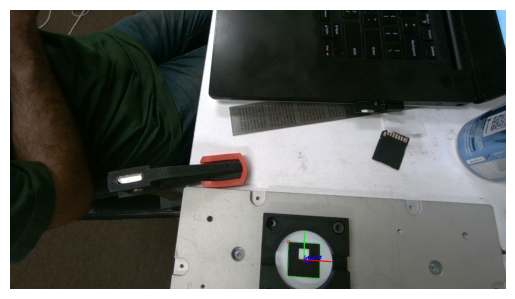

True

In [7]:
# camera
camera = Camera()
print("Camera connected: ", camera.connect())

# Robot
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))

# kinematics
kinematic = Kinematic(robot_model)

# update collected data
collected_data.append(dorna_ta_eye_in_hand_camera_kit(robot, kinematic, camera, joint_deviation, aruco_id, aruco_length, aruco_dic, aruco_refine, aruco_subpix, aruco_coordinate))  

# close the connections
camera.close()
robot.close()

In [8]:
camera.close()
robot.close()

True

In [ ]:
collected_data